In [1]:
import os
import json
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split, TensorDataset
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from tqdm import tqdm
from PIL import Image

In [2]:
# Check for GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


### Data Pre-processing

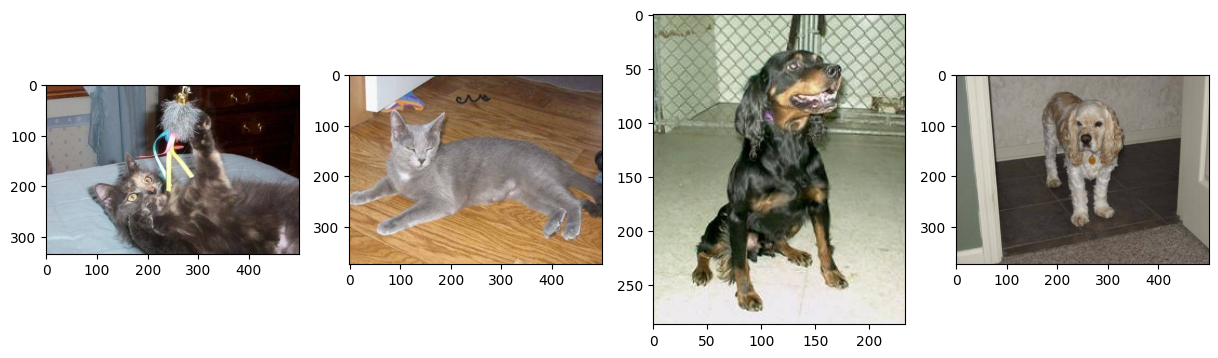

In [3]:
DATASET_FOLDER = 'datasets/train'

cat_images = []
dog_images = []

for filename in os.listdir(os.path.join(DATASET_FOLDER, 'cat')):
    if filename.endswith('.jpg'):
        img_path = os.path.join(DATASET_FOLDER, 'cat', filename)
        if os.path.isfile(img_path):
            img = Image.open(img_path)
            cat_images.append(img)
            if len(cat_images) >= 2:
                break

# Load dog images
for filename in os.listdir(os.path.join(DATASET_FOLDER, 'dog')):
    if filename.endswith('.jpg'):
        img_path = os.path.join(DATASET_FOLDER, 'dog', filename)
        if os.path.isfile(img_path):
            img = Image.open(img_path)
            dog_images.append(img)
            if len(dog_images) >= 2:
                break

images = cat_images + dog_images

plt.figure(figsize=(15, 10))
for i, img in enumerate(images):
    plt.subplot(1, len(images), i + 1)
    plt.imshow(img)
    plt.axis('on')  # Show axis
plt.show()

Within the folder, there are more than 10k images for both cats and dogs (total of 20k images)

Now we need to convert the image into same size to enable the model to analyze later.

Let's create a folder called train in the root directory and combine both picture of cats and dogs after the image resize

We first decide our image to be 64 x 64 px, however the validation accuracy is not high enough, therefore we decided to up the image resize into 128 x 128 px
We also try to use 256 x 256 px, however it needs too much ram and our devide could not handle the required computing power

In [4]:
DATASET_FOLDER = 'datasets/train'
OUTPUT_FOLDER = 'train'

os.makedirs(OUTPUT_FOLDER, exist_ok=True)

def resize_and_save_all_images(folder_name, output_folder):
    count = 0
    for filename in os.listdir(os.path.join(DATASET_FOLDER, folder_name)):
        if filename.endswith('.jpg'):  # Check if the file is a .jpg
            img_path = os.path.join(DATASET_FOLDER, folder_name, filename)
            if os.path.isfile(img_path):
                img = Image.open(img_path)  # Load image using Pillow
                img_resized = img.resize((128, 128))  # Resize image to 128 x 128
                img_resized.save(os.path.join(output_folder, f"{folder_name}_{count}.jpg"))
                count += 1

# Resize and save all cat and dog images
resize_and_save_all_images('cat', OUTPUT_FOLDER)
resize_and_save_all_images('dog', OUTPUT_FOLDER)

print("All images resized and saved successfully.")

All images resized and saved successfully.


Now, Let's see our new images

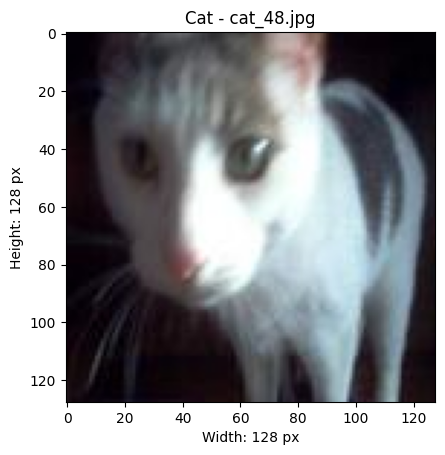

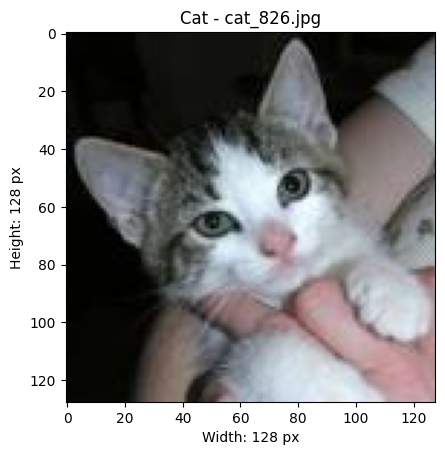

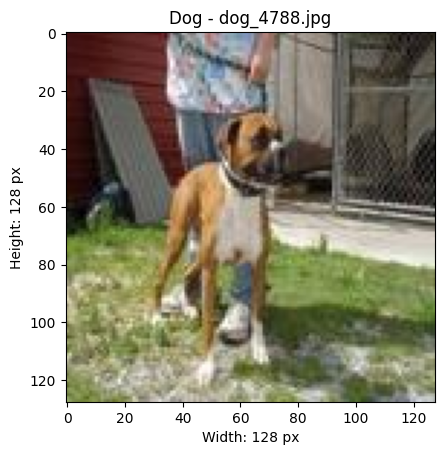

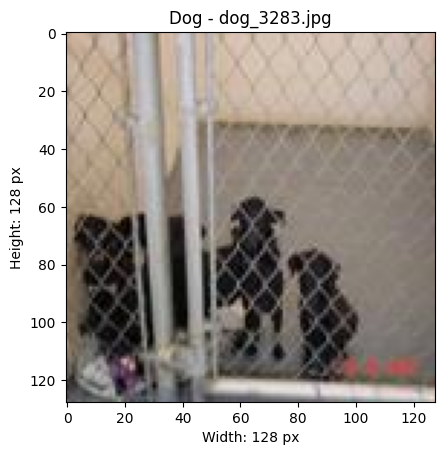

In [5]:
NEW_FOLDER = 'train'

def display_images(category, num_images):
    images_shown = 0
    for filename in os.listdir(NEW_FOLDER):
        if filename.startswith(category) and filename.endswith('.jpg'):
            img_path = os.path.join(NEW_FOLDER, filename)
            img = Image.open(img_path)
            plt.imshow(img)
            plt.title(f"{category.capitalize()} - {filename}")
            plt.axis("on")
            plt.xlabel(f"Width: {img.width} px")
            plt.ylabel(f"Height: {img.height} px")
            plt.show()
            
            images_shown += 1
            if images_shown >= num_images:
                break

display_images('cat', num_images=2)
display_images('dog', num_images=2)

Now we can see each image will consist of 128 x 128 px.

Now we will convert this image into numerical data. the idea is to convert each pixels into 3 values representing rgb colors

image augmentation

In [6]:
data_dir = "train"
img_size = 128

# Picture Augmentation
augmentation_transforms = [
    transforms.Resize((img_size, img_size)),
    transforms.RandomRotation(180),
    transforms.RandomHorizontalFlip(),
    transforms.RandomAffine(0, scale=(0.5, 1.2), shear=20),
    transforms.ColorJitter(brightness=0.2, contrast=0.2)
]

def augment_and_save_images(data_dir, img_size=128):
    transform = transforms.Compose(augmentation_transforms)
    
    for filename in os.listdir(data_dir):
        if filename.endswith('.jpg'):
            img_path = os.path.join(data_dir, filename)
            img = Image.open(img_path).convert("RGB")
            
            augmented_img = transform(img)
            
            # Save with "_aug" suffix in the same folder
            base_filename = filename.split('.')[0]
            new_filename = f"{base_filename}_aug.jpg"
            augmented_img_path = os.path.join(data_dir, new_filename)
            augmented_img.save(augmented_img_path)


augment_and_save_images(data_dir, img_size)
print(f"Saved augmented image")


Saved augmented image


Let's see the image aug

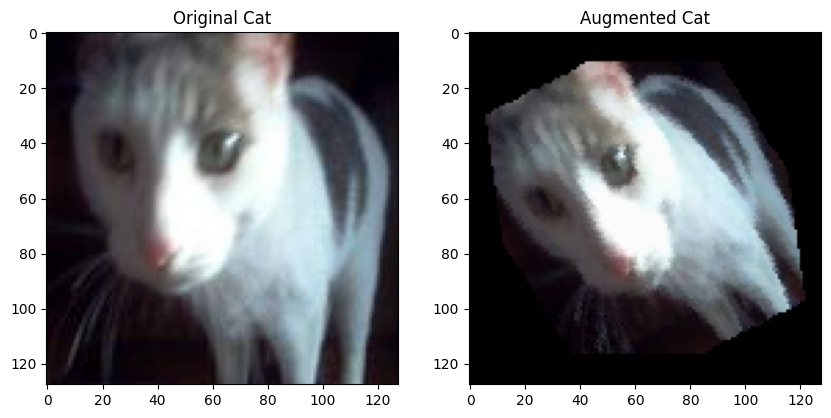

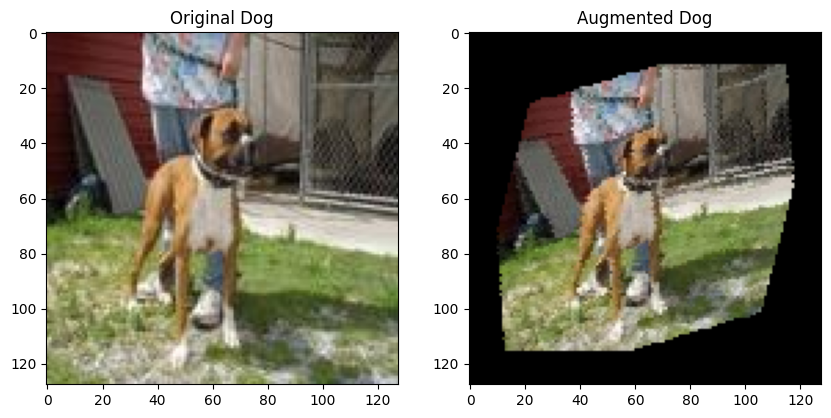

In [7]:
data_dir = "train"
img_size = 128

augmentation_transforms = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.RandomRotation(40),
    transforms.RandomHorizontalFlip(),
    transforms.RandomAffine(0, scale=(0.8, 1.2), shear=20),
    transforms.ColorJitter(brightness=0.2, contrast=0.2)
])

def show_original_and_augmented(data_dir, category, img_size=128):
    for filename in os.listdir(data_dir):
        if filename.startswith(category) and filename.endswith('.jpg'):
            img_path = os.path.join(data_dir, filename)
            img = Image.open(img_path).convert("RGB")

            augmented_img = augmentation_transforms(img)
            
            fig, axes = plt.subplots(1, 2, figsize=(10, 5))
            axes[0].imshow(img)
            axes[0].set_title(f"Original {category.capitalize()}")
            axes[0].axis("on")
            axes[1].imshow(augmented_img)
            axes[1].set_title(f"Augmented {category.capitalize()}")
            axes[1].axis("on")
            plt.show()
            
            break

# Display one cat and one dog image, along with their augmented versions
show_original_and_augmented(data_dir, 'cat', img_size)
show_original_and_augmented(data_dir, 'dog', img_size)


Now, we convert every image into rgb and store into a csv file

In [8]:
# Initialize a list to hold the image data and labels
data = []
labels = []

# Loop through the images in the data directory
for filename in os.listdir(data_dir):
    if filename.endswith('.jpg'):
        img_path = os.path.join(data_dir, filename)
        img = Image.open(img_path).convert("RGB")  # Open image as RGB
        
        img_array = np.array(img)  # Convert image to NumPy array
        
        # Append image data (as a list) and label (0 for cat, 1 for dog)
        data.append(img_array)
        
        # Set the label based on the filename
        if filename.startswith("dog"):
            labels.append(1)
        elif filename.startswith("cat"):
            labels.append(0)

# Create a DataFrame with the image data and labels
df = pd.DataFrame({
    'pixels': data,
    'label': labels
})

In [9]:
df.head(5)

,pixels,label
0,"[[[62, 16, 18], [62, 16, 18], [63, 17, 17], [6...",1
1,"[[[177, 149, 127], [194, 166, 144], [210, 182,...",1
2,"[[[3, 0, 7], [3, 0, 7], [3, 0, 7], [3, 0, 7], ...",0
3,"[[[179, 167, 155], [172, 160, 148], [171, 159,...",1
4,"[[[3, 3, 1], [3, 3, 1], [3, 3, 1], [3, 3, 1], ...",0


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   pixels  40000 non-null  object
 1   label   40000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 625.1+ KB


In [11]:
print(df['pixels'][0].shape) # Shape for the pixels

(128, 128, 3)


In [12]:
# df.to_pickle('train_128.pkl') # optional

#### Test Data Preparation

In [13]:
DATASET_FOLDER = 'datasets/val'
OUTPUT_FOLDER = 'test'

os.makedirs(OUTPUT_FOLDER, exist_ok=True)

def resize_and_save_all_images(folder_name, output_folder):
    count = 0
    for filename in os.listdir(os.path.join(DATASET_FOLDER, folder_name)):
        if filename.endswith('.jpg'):
            img_path = os.path.join(DATASET_FOLDER, folder_name, filename)
            if os.path.isfile(img_path):
                img = Image.open(img_path)
                img_resized = img.resize((128, 128))
                img_resized.save(os.path.join(output_folder, f"{folder_name}_{count}.jpg"))
                count += 1

resize_and_save_all_images('cat', OUTPUT_FOLDER)
resize_and_save_all_images('dog', OUTPUT_FOLDER)

print("All images resized and saved successfully.")

All images resized and saved successfully.


In [14]:
data_dir = "test"
img_size = 128

data = []
labels = []

for filename in os.listdir(data_dir):
    if filename.endswith('.jpg'):
        img_path = os.path.join(data_dir, filename)
        img = Image.open(img_path).convert("RGB")
        
        img_array = np.array(img)
        
        # Append image data (as a list) and label (0 for cat, 1 for dog)
        data.append(img_array)
        
        # Set the label based on the filename
        if filename.startswith("dog"):
            labels.append(1)
        elif filename.startswith("cat"):
            labels.append(0)

# Create a DataFrame with the image data and labels
df_test = pd.DataFrame({
    'pixels': data,
    'label': labels
})

In [15]:
df_test.head()

,pixels,label
0,"[[[1, 1, 1], [1, 1, 1], [1, 1, 1], [2, 2, 2], ...",0
1,"[[[214, 176, 111], [215, 177, 112], [217, 177,...",0
2,"[[[57, 53, 24], [61, 60, 30], [66, 64, 39], [4...",0
3,"[[[126, 133, 115], [96, 103, 85], [83, 86, 69]...",1
4,"[[[57, 67, 77], [60, 72, 84], [58, 71, 87], [6...",0


In [16]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   pixels  5000 non-null   object
 1   label   5000 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 78.3+ KB


In [17]:
print(df_test['pixels'][0].shape) # Shape for the pixels

(128, 128, 3)


In [18]:
# df_test.to_pickle('test_128.pkl') # Save the dataset (optional)

Model Architecture and Hyper-parameter tuning, please look at finetuning.ipynb